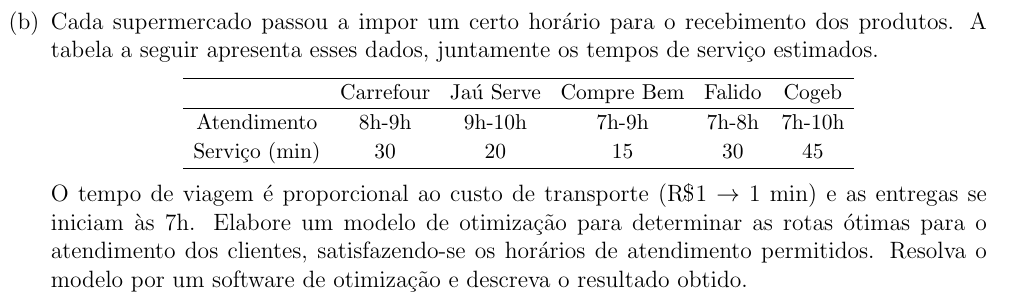

In [2]:
from IPython.display import Image
Image(filename='images/1b.png')

In [12]:
# Bibliotecas
import pyomo.environ as pyo
from pyomo.environ import *
from pyomo.opt import SolverFactory
import xlwings as xw
import pandas as pd

In [13]:
# Dados
wb = xw.Book('dados_1.xlsx')
sheet = wb.sheets['Plan1']

# Conjuntos
Clientes = sheet.range("C2:G2").value
n = len(Clientes)  # Número de clientes (5)

Veiculos = sheet.range("A12:A14").value

Nos = [i for i in range(n + 2)]

# Parâmetros
custo_transporte = sheet.range("A2:H9").options(pd.DataFrame).value
custo_transporte = custo_transporte.stack().to_dict()

demanda = sheet.range("D12:E18").options(dict).value

capacidade = sheet.range("A12:B14").options(dict).value

In [14]:
# Modelo
model = ConcreteModel()

# Conjuntos
model.C = Set(initialize=Clientes)
model.K = Set(initialize=Veiculos)
model.N = Set(initialize=Nos)
C, K, N = model.C, model.K, model.N

# Parâmetros
model.Q = Param(K, initialize=capacidade, within=NonNegativeReals)
model.d = Param(N, initialize=demanda, within=NonNegativeReals)
model.c = Param(N * N, initialize=custo_transporte, within=NonNegativeReals)
Q, d, c = model.Q, model.d, model.c

# Variáveis de decisão
model.x = Var(N * N * K, within=Binary)
x = model.x

# Função objetivo
model.obj = Objective(expr=sum(sum(sum(c[i, j] * x[i, j, k] for j in N) for i in N) for k in K))

# Restrições

# 1) Cada cliente visitado uma vez
model.r_visita = ConstraintList()
for i in C:
    model.r_visita.add(expr=sum(sum(x[i, j, k] for j in N if (j > 0 and j != i)) for k in K) == 1)
    
# 2) O mesmo veículo visita antecessor/sucessor
model.r_fluxo = ConstraintList()
for h in C:
    for k in K:
        model.r_fluxo.add(expr=sum(x[i, h, k] for i in N if (i < (n + 1) and i != h)) == 
                                   sum(x[h, j, k] for j in N if (j > 0 and j != h)))

# 3) Capacidade máxima do veículo
model.r_capacidade = ConstraintList()
for k in K:
    model.r_capacidade.add(expr=sum(sum(d[i] * x[i, j, k] for i in C) for j in N if (j != i and j > 0)) <= Q[k])

# 4) Cada veículo deve sair do depósito
model.r_saida = ConstraintList()
for k in K:
    model.r_saida.add(expr=sum(x[0, j, k] for j in N if j > 0) == 1)

# 5) Cada veículo deve retornar ao depósito
model.r_retorno = ConstraintList()
for k in K:
    model.r_retorno.add(expr=sum(x[i, n + 1, k] for i in N if i < (n + 1)) == 1)

In [15]:
# Formulação de MTZ
model.u = Var(N * K, within=NonNegativeReals)
u = model.u

model.r_u = ConstraintList()
for i in C:
    for k in K:
        model.r_u.add(expr=u[i,k] <= Q[k])
for i in N:
    if i != n + 1:
        for j in C:
            if i != j:
                for k in K:
                    model.r_u.add(expr=u[j,k] >= u[i,k] + d[j]*x[i,j,k] + Q[k]*(x[i,j,k] - 1))

In [16]:
tempo_viagem = custo_transporte.copy()
tempo_servico = sheet.range("G21:H27").options(dict).value
horario_inicial = sheet.range("A21:B27").options(dict).value
horario_final = sheet.range("D21:E27").options(dict).value

In [17]:
# Criação de variável e restrições de tempo

# Parâmetros (tempo de viagem)
model.p = Param(N * N, initialize=tempo_viagem, within=NonNegativeReals)
model.s = Param(N, initialize=tempo_servico, within=NonNegativeReals)
model.f = Param(N, initialize=horario_final, within=NonNegativeReals)
model.l = Param(N, initialize=horario_inicial, within=NonNegativeReals)
p, s, f, l = model.p, model.s, model.f, model.l

# Variável de decisão
model.t = Var(N * K, within=NonNegativeReals)
t = model.t

# Restrições
# Tempo inicial
model.r_tempo_inicio = ConstraintList()
for k in K:
    model.r_tempo_inicio.add(expr=t[0, k] == 420)

# Tempo viajado
model.r_tempo_viajado = ConstraintList()
for i in N:
    if i != n + 1:
        for j in N:
            if i != j:
                for k in K:
                    model.r_tempo_viajado.add(expr=t[j, k] >= t[i, k] + s[i] * x[i, j, k] + 
                                                   p[i, j] * x[i, j, k] + 100000 * (x[i, j, k] - 1))

# Horários de término e início
model.r_horario = ConstraintList()
for k in K:
    for i in C:
        model.r_horario.add(expr=t[i, k] <= f[i])
        model.r_horario.add(expr=t[i, k] >= l[i])

In [18]:
# Resolução
solver = SolverFactory('glpk')
resultado = solver.solve(model, tee = False)

In [19]:
if (resultado.solver.status == SolverStatus.ok) and (resultado.solver.termination_condition != TerminationCondition.infeasible):
    print(f'Custo mínimo: R${value(model.obj)}')
    print()
    for k in K:
        for i in N:
            if i < n + 1:
                for j in N:
                    if i != j:
                        if j > 0:
                            if value(model.x[i,j,k]) == 1:
                                print(f'O {k} vai de {i} para {j}')
else:
     print(resultado.solver.termination_condition)

Custo mínimo: R$68.0

O Caminhao 1 vai de 0 para 1
O Caminhao 1 vai de 1 para 2
O Caminhao 1 vai de 2 para 6
O Caminhao 2 vai de 0 para 3
O Caminhao 2 vai de 3 para 4
O Caminhao 2 vai de 4 para 5
O Caminhao 2 vai de 5 para 6
O Caminhao 3 vai de 0 para 6
